In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.ndimage import convolve1d
import imageio
%matplotlib inline

In [18]:
N = 15
M = [0,0,0,1,1,1,0,1,1,1]*N
K = [1,1,1]
O = [0,0,1]
M1 = [1,0,1,0,1,1,1,0,0,0,0,1,0,1,1,0,1]*N

In [3]:
def evolution(M, K, O, mode='wrap'):
    kws = dict(mode=mode)
    res = convolve1d(M,K,**kws)
    ones = convolve1d(M,O,**kws)
    
    true_zeros = (res == 1) & (ones == 1)
    res[true_zeros] = 0
    res[res == 3] = 0
    res[res == 2] = 1
    res[res == 0] = 0
    
    return res

In [4]:
def living_cells(X):
    return np.sum(X)

In [5]:
def pic(M,name):
    fig, ax = plt.subplots(figsize=(8,6))
    ax.set_aspect('auto')
    ax.imshow(M, interpolation='nearest', cmap=cm.Greys)
    ax.axis('off')
    fig.savefig(name)
    plt.close(fig);

In [6]:
plt.ioff()

x = len(M)
y = 100
Results = np.empty((y,x))
Results[0,:] = M
alive = list()

files = list()
for i in range(1,y):
    pic(Results,f"{i+100}_pic.png")
    Results[i,:] = evolution(Results[i-1,:],K,O)
    files.append(f"{i+100}_pic.png")
    alive.append(living_cells(Results[i,:]))
    
images = list()
for file in files:
    images.append(imageio.imread(file))
imageio.mimsave(f'110.gif', images, fps = 13);   

C:\Users\ivang\AppData\Local\Temp\ipykernel_11516\2931297664.py:18: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file))


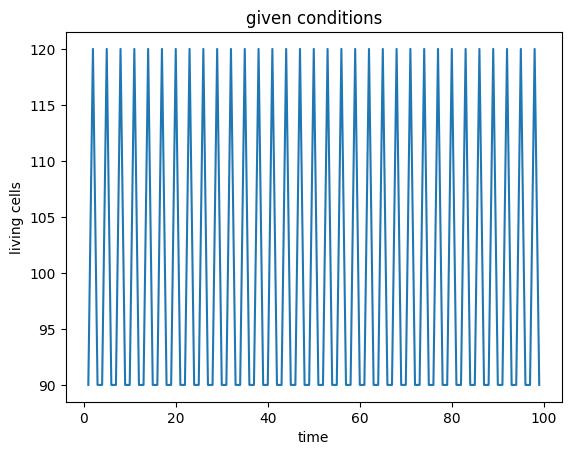

In [17]:

plt.plot(np.arange(1,y),alive)
plt.title('given conditions')
plt.xlabel('time')
plt.ylabel('living cells')
plt.show()

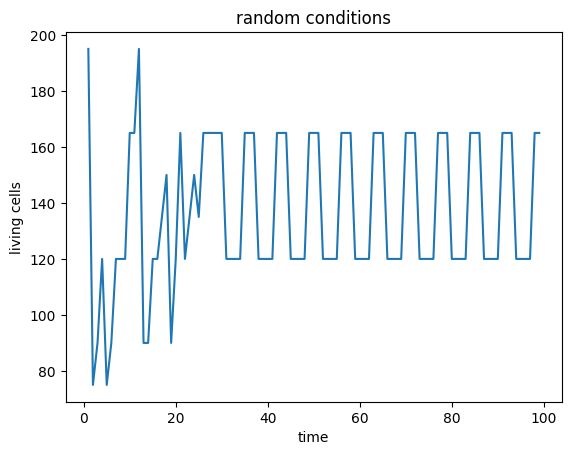

In [24]:
x = len(M1)
y = 100
Results = np.empty((y,x))
Results[0,:] = M1
alive = list()

files = list()
for i in range(1,y):
    Results[i,:] = evolution(Results[i-1,:],K,O)
    alive.append(living_cells(Results[i,:]))  

plt.plot(np.arange(1,y),alive)
plt.title('random conditions')
plt.xlabel('time')
plt.ylabel('living cells')
plt.show()   


In [19]:
%%writefile game.py
import matplotlib.pyplot as plt
from mpi4py import MPI
import numpy as np
import matplotlib.cm as cm
from scipy.ndimage import convolve1d
import imageio

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

if size > 1:
    cartesian = comm.Create_cart(dims = [size],periods =[True],reorder=False)


def neighbours(rank, size):
    left,right = cartesian.Shift(direction = 0,disp=1)
    return left, right


def send_ghost(obj_l, obj_r, func, rank, size):
    left, right = func(rank,size)
    comm.send(obj_l, dest = left)
    comm.send(obj_r, dest = right)

def recv_ghost(func, rank, size):
    left, right = func(rank,size)
    ghost_r = comm.recv(source = right)
    ghost_l = comm.recv(source = left)
    return ghost_l, ghost_r


def evolution(M, K, O, mode='wrap'):
    kws = dict(mode=mode)
    res = convolve1d(M,K,**kws)
    ones = convolve1d(M,O,**kws)
    
    true_zeros = (res == 1) & (ones == 1)
    res[true_zeros] = 0
    res[res == 3] = 0
    res[res == 2] = 1
    res[res == 0] = 0
    
    return res


def pic(M,name):
    fig, ax = plt.subplots(figsize=(8,6))
    ax.set_aspect('auto')
    ax.imshow(M, interpolation='nearest', cmap=cm.Greys)
    ax.axis('off')
    fig.savefig(name)
    plt.close(fig);


N = 10
M = [0,0,0,1,1,1,0,1,1,1]*N
K = [1,1,1]
O = [0,0,1]

    
step, residue = divmod(len(M),size)


if rank != (size-1):
    l_bord = rank*step
    r_bord = (rank+1)*step
else:
    l_bord = rank*step
    r_bord = (rank+1)*step + residue
    


if rank == 0:
    data = np.empty((len(M),len(M)))
    data[0,:] = M
    files = list()

X = M[l_bord:r_bord]

for i in range(1,len(M)):
    if size > 1:
        send_ghost(X[0],X[-1],neighbours, rank, size)
        ghost_l, ghost_r = recv_ghost(neighbours, rank, size)
    
        X = np.insert(X, 0, ghost_l)
        X = np.append(X, ghost_r)
        X = evolution(X, K, O)
        X = np.delete(X,[0,-1])
    else:
        X = evolution(X,K,O)
        
    res = comm.gather([X,[l_bord,r_bord]], root = 0)
    
    if rank == 0:
        
        for j in range(len(res)):
            index = res[j][1]
            data[i,index[0]:index[1]] = res[j][0]
        
        files.append(f'{i+100}_pic.png')
        pic(data, f'{i+100}_pic.png')
        

if rank == 0:
    images = list()
    for file in files:
        images.append(imageio.imread(file))
    imageio.mimsave(f'111.gif', images, fps = 13)
    print('all done')


Overwriting game.py


In [22]:
!mpiexec -np 1 python game.py

all done


C:\Users\ivang\Desktop\skoltech_courses\HPPL\rule\game.py:108: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file))


In [25]:
import os
files = [file for file in os.listdir(os.getcwd()) if file.endswith('.png')]
for file in files:
    os.remove(file)